In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dotenv import load_dotenv
import json
from utils import *
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


In [2]:
def explore_database(db_path):
    """Explore database schema"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Get all tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [row[0] for row in cursor.fetchall()]
    
    print(f"📊 Database: {db_path}")
    print(f"📋 Tables found: {len(tables)}\n")
    
    schema = {}
    for table in tables:
        cursor.execute(f"PRAGMA table_info({table})")
        columns = cursor.fetchall()
        schema[table] = [col[1] for col in columns]
        print(f"  • {table}: {', '.join(schema[table][:5])}{'...' if len(schema[table]) > 5 else ''}")
    
    conn.close()
    return schema

# Explore chinook database
schema = explore_database("../data/chinook.db")

📊 Database: ../data/chinook.db
📋 Tables found: 13

  • albums: AlbumId, Title, ArtistId
  • sqlite_sequence: name, seq
  • artists: ArtistId, Name
  • customers: CustomerId, FirstName, LastName, Company, Address...
  • employees: EmployeeId, LastName, FirstName, Title, ReportsTo...
  • genres: GenreId, Name
  • invoices: InvoiceId, CustomerId, InvoiceDate, BillingAddress, BillingCity...
  • invoice_items: InvoiceLineId, InvoiceId, TrackId, UnitPrice, Quantity
  • media_types: MediaTypeId, Name
  • playlists: PlaylistId, Name
  • playlist_track: PlaylistId, TrackId
  • tracks: TrackId, Name, AlbumId, MediaTypeId, GenreId...
  • sqlite_stat1: tbl, idx, stat


In [3]:
schema_str = str(schema)

In [4]:
len(schema_str)

1000

In [5]:
context_usage=calculate_context_percentage(schema_str)

In [6]:
context_usage

{'tokens': 288,
 'percentage': 0.22499999999999998,
 'context_window': 128000,
 'remaining': 127712,
 'fits': True}

In [7]:
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())

True

In [8]:
token = os.getenv("OPEENAI_API_KEY")
model = 'o4-mini'

llm = ChatOpenAI(
    openai_api_base="https://chat.int.bayer.com/api/v2",
    openai_api_key=token,
    model=model,
    temperature=0.0
)


In [9]:
import pandas as pd

class DataAnalysisAgent:
    """Analyzes data using LLM-generated SQL"""
    
    def __init__(self, db_path, llm, schema):
        self.db_path = db_path
        self.llm = llm
        self.schema = schema
        self.conn = sqlite3.connect(db_path)
        
    def analyze(self, user_query: str, allowed_tables: list = None) -> dict:
        """Main analysis method"""
        print(f"\n{'='*60}")
        print(f"🔍 Query: {user_query}")
        print(f"{'='*60}")
        
        # Step 1: Generate SQL
        sql_query = self._generate_sql(user_query, allowed_tables)
        print(f"\n💻 Generated SQL:\n{sql_query}\n")
        
        # Step 2: Execute with safety checks
        if self._is_safe_query(sql_query):
            try:
                df = pd.read_sql_query(sql_query, self.conn)
                print(f"✅ Query executed: {len(df)} rows returned\n")
                
                # Step 3: Generate insights
                insights = self._generate_insights(user_query, df)
                
                return {
                    "status": "success",
                    "query": user_query,
                    "sql": sql_query,
                    "data": df,
                    "insights": insights,
                    "rows": len(df)
                }
            except Exception as e:
                return {
                    "status": "error",
                    "error": str(e),
                    "query": user_query
                }
        else:
            return {
                "status": "error",
                "error": "Unsafe query detected",
                "query": user_query
            }
    
    def _generate_sql(self, user_query: str, allowed_tables: list = None) -> str:
        """Generate SQL from natural language"""
        tables_info = "\n".join([
            f"- {table}: {', '.join(cols)}"
            for table, cols in self.schema.items()
            if allowed_tables is None or table in allowed_tables
        ])
        
        prompt = ChatPromptTemplate.from_template(
            """You are an expert SQL generator for SQLite databases.           
                DATABASE SCHEMA:
                {schema}
                USER QUERY: {query}
                Generate a safe, efficient SELECT query. Rules:
                1. ONLY use SELECT statements (no INSERT, UPDATE, DELETE, DROP)
                2. Include LIMIT clause if not specified (default LIMIT 100)
                3. Use proper JOINs when needed
                4. Return ONLY the SQL query, no explanations
                SQL Query:""")
        
        response = self.llm.invoke(prompt.format(schema=tables_info, query=user_query))
        
        # Clean the response
        sql = response.content.strip()
        # Remove markdown code blocks if present
        sql = sql.replace("```sql", "").replace("```", "").strip()
        
        return sql
    
    def _is_safe_query(self, sql: str) -> bool:
        """Check if SQL query is safe"""
        sql_upper = sql.upper()
        dangerous_keywords = ['DROP', 'DELETE', 'UPDATE', 'INSERT', 'ALTER', 'CREATE', 'TRUNCATE']
        
        for keyword in dangerous_keywords:
            if keyword in sql_upper:
                print(f"⚠️  Dangerous keyword detected: {keyword}")
                return False
        return True
    
    def _generate_insights(self, query: str, df: pd.DataFrame) -> str:
        """Generate natural language insights"""
        data_summary = df.head(10).to_string()
        
        prompt = ChatPromptTemplate.from_template(
            """Based on this query and results, provide 2-3 key insights in bullet points.
                QUERY: {query}
                RESULTS (first 10 rows):
                {data}
                Key Insights (2-3 bullets):""")
        
        response = self.llm.invoke(prompt.format(query=query, data=data_summary))
        
        return response.content.strip()
    
    def close(self):
        self.conn.close()

analysis_agent = DataAnalysisAgent("../data/chinook.db", llm, schema)

In [10]:
analysis_agent.analyze("Give me top 10 artist with most albulmns")


🔍 Query: Give me top 10 artist with most albulmns

💻 Generated SQL:
SELECT
  artists.ArtistId,
  artists.Name,
  COUNT(albums.AlbumId) AS AlbumCount
FROM artists
LEFT JOIN albums ON artists.ArtistId = albums.ArtistId
GROUP BY artists.ArtistId, artists.Name
ORDER BY AlbumCount DESC
LIMIT 10;

✅ Query executed: 10 rows returned



{'status': 'success',
 'query': 'Give me top 10 artist with most albulmns',
 'sql': 'SELECT\n  artists.ArtistId,\n  artists.Name,\n  COUNT(albums.AlbumId) AS AlbumCount\nFROM artists\nLEFT JOIN albums ON artists.ArtistId = albums.ArtistId\nGROUP BY artists.ArtistId, artists.Name\nORDER BY AlbumCount DESC\nLIMIT 10;',
 'data':    ArtistId             Name  AlbumCount
 0        90      Iron Maiden          21
 1        22     Led Zeppelin          14
 2        58      Deep Purple          11
 3        50        Metallica          10
 4       150               U2          10
 5       114    Ozzy Osbourne           6
 6       118        Pearl Jam           5
 7        21  Various Artists           4
 8        82    Faith No More           4
 9        84     Foo Fighters           4,
 'insights': '• Iron Maiden leads by a wide margin with 21 albums—50% more than the next‐highest artist (Led Zeppelin at 14).  \n• The top five are all major rock/metal acts, each boasting ten or more albums (I

In [11]:
# Company Style Configuration for plottinng and visualziations
COMPANY_STYLE = {
    "colors": ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#6A994E"],
    "font_size": 12,
    "figure_size": (10, 6),
    "dpi": 100
}

sns.set_palette(COMPANY_STYLE["colors"])
plt.rcParams['figure.figsize'] = COMPANY_STYLE["figure_size"]
plt.rcParams['figure.dpi'] = COMPANY_STYLE["dpi"]


In [12]:
class VisualizationAgent:
    """Creates visualizations with company branding"""
    
    def __init__(self, llm, style_config=COMPANY_STYLE):
        self.llm = llm
        self.style = style_config
        
    def visualize(self, data: pd.DataFrame, query: str, output_dir="../outputs") -> dict:
        """Create appropriate visualization"""
        print(f"\n{'='*60}")
        print(f"📊 Creating Visualization")
        print(f"{'='*60}")
        
        # Step 1: Determine chart type
        chart_type = self._determine_chart_type(data, query)
        print(f"📈 Chart type: {chart_type}\n")
        
        # Step 2: Create visualization
        fig, ax = plt.subplots(figsize=self.style['figure_size'])
        
        if chart_type == 'bar':
            self._create_bar_chart(data, ax)
        elif chart_type == 'line':
            self._create_line_chart(data, ax)
        elif chart_type == 'pie':
            self._create_pie_chart(data, ax)
        elif chart_type == 'scatter':
            self._create_scatter_plot(data, ax)
        else:
            self._create_bar_chart(data, ax)  # default
        
        # Apply company branding
        self._apply_branding(ax, query)
        
        # Save
        os.makedirs(output_dir, exist_ok=True)
        filename = f"viz_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.png"
        filepath = os.path.join(output_dir, filename)
        plt.tight_layout()
        plt.savefig(filepath, dpi=self.style['dpi'], bbox_inches='tight')
        
        print(f"Saved: {filepath}\n")
        
        plt.show()
        
        return {
            "status": "success",
            "chart_type": chart_type,
            "filepath": filepath
        }
    
    def _determine_chart_type(self, df: pd.DataFrame, query: str) -> str:
        """Use LLM to determine best chart type"""
        data_info = f"Columns: {list(df.columns)}, Rows: {len(df)}, Types: {df.dtypes.to_dict()}"
        
        prompt = ChatPromptTemplate.from_template(
            """Given this data and query, suggest ONE chart type.
                DATA INFO: {data_info}
                QUERY: {query}
                Choose from: bar, line, pie, scatter
                Return ONLY the chart type, nothing else:""")
        
        response = self.llm.invoke(prompt.format(data_info=data_info, query=query))
        
        chart_type = response.content.strip().lower()
        return chart_type if chart_type in ['bar', 'line', 'pie', 'scatter'] else 'bar'
    
    def _create_bar_chart(self, df, ax):
        """Create bar chart"""
        # Use first column as x, second as y
        if len(df.columns) >= 2:
            x_col, y_col = df.columns[0], df.columns[1]
            df_plot = df.head(10)  # Limit to top 10
            ax.bar(range(len(df_plot)), df_plot[y_col], color=self.style['colors'][0])
            ax.set_xticks(range(len(df_plot)))
            ax.set_xticklabels(df_plot[x_col], rotation=45, ha='right')
            ax.set_xlabel(x_col)
            ax.set_ylabel(y_col)
    
    def _create_line_chart(self, df, ax):
        """Create line chart"""
        if len(df.columns) >= 2:
            x_col, y_col = df.columns[0], df.columns[1]
            ax.plot(df[x_col], df[y_col], marker='o', color=self.style['colors'][0], linewidth=2)
            ax.set_xlabel(x_col)
            ax.set_ylabel(y_col)
            ax.grid(True, alpha=0.3)
    
    def _create_pie_chart(self, df, ax):
        """Create pie chart"""
        if len(df.columns) >= 2:
            labels_col, values_col = df.columns[0], df.columns[1]
            df_plot = df.head(10)
            ax.pie(df_plot[values_col], labels=df_plot[labels_col], autopct='%1.1f%%',
                   colors=self.style['colors'])
    
    def _create_scatter_plot(self, df, ax):
        """Create scatter plot"""
        if len(df.columns) >= 2:
            x_col, y_col = df.columns[0], df.columns[1]
            ax.scatter(df[x_col], df[y_col], alpha=0.6, color=self.style['colors'][0])
            ax.set_xlabel(x_col)
            ax.set_ylabel(y_col)
            ax.grid(True, alpha=0.3)
    
    def _apply_branding(self, ax, query):
        """Apply company branding"""
        # Title based on query (simplified)
        title = query[:50] + "..." if len(query) > 50 else query
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        
        # Company watermark
        ax.text(0.99, 0.01, 'Company Analytics ©', 
                transform=ax.transAxes,
                fontsize=8, alpha=0.5,
                ha='right', va='bottom')

In [13]:
viz_agent = VisualizationAgent(llm)

In [14]:
def run_complete_workflow(query, user_role="analyst"):
    """Run complete analysis + visualization workflow"""
    
    # Define permissions (simulated)
    permissions = {
        "analyst": ["artists", "albums", "tracks", "invoices", "customers"],
        "viewer": ["artists", "albums", "tracks"],
        "admin": None  # all tables
    }
    
    allowed_tables = permissions.get(user_role)
    
    # Step 1: Analysis
    analysis_result = analysis_agent.analyze(query, allowed_tables)
    
    if analysis_result["status"] == "success":
        print(analysis_result["insights"])
        print(f"\nData shape: {analysis_result['data'].shape}")
        display(analysis_result["data"].head())
        
        # Step 2: Visualization
        viz_result = viz_agent.visualize(analysis_result["data"], query)
        
        return {
            "analysis": analysis_result,
            "visualization": viz_result
        }
    else:
        print(f"Error: {analysis_result.get('error')}")
        return analysis_result



TEST 1: Top 10 Selling Artists

🔍 Query: Show me the top 10 artists by total sales amount

💻 Generated SQL:
SELECT artists.Name AS ArtistName,
       SUM(invoice_items.UnitPrice * invoice_items.Quantity) AS TotalSales
FROM artists
JOIN albums ON albums.ArtistId = artists.ArtistId
JOIN tracks ON tracks.AlbumId = albums.AlbumId
JOIN invoice_items ON invoice_items.TrackId = tracks.TrackId
GROUP BY artists.ArtistId, artists.Name
ORDER BY TotalSales DESC
LIMIT 10;

✅ Query executed: 10 rows returned

• Iron Maiden is the clear leader with $138.60 in total sales, roughly 30% more than the runner-up (U2 at $105.93).  
• Classic rock and heavy metal dominate the top four spots (Iron Maiden, U2, Metallica, Led Zeppelin), each exceeding $80 in sales.  
• There’s a steep drop-off after the top five—artists ranked 6–10 all generate under $50 in total sales.

Data shape: (10, 2)


,ArtistName,TotalSales
0,Iron Maiden,138.60
1,U2,105.93
2,Metallica,90.09
3,Led Zeppelin,86.13
4,Lost,81.59



📊 Creating Visualization
📈 Chart type: bar

✅ Saved: ../outputs/viz_20251030_161630.png



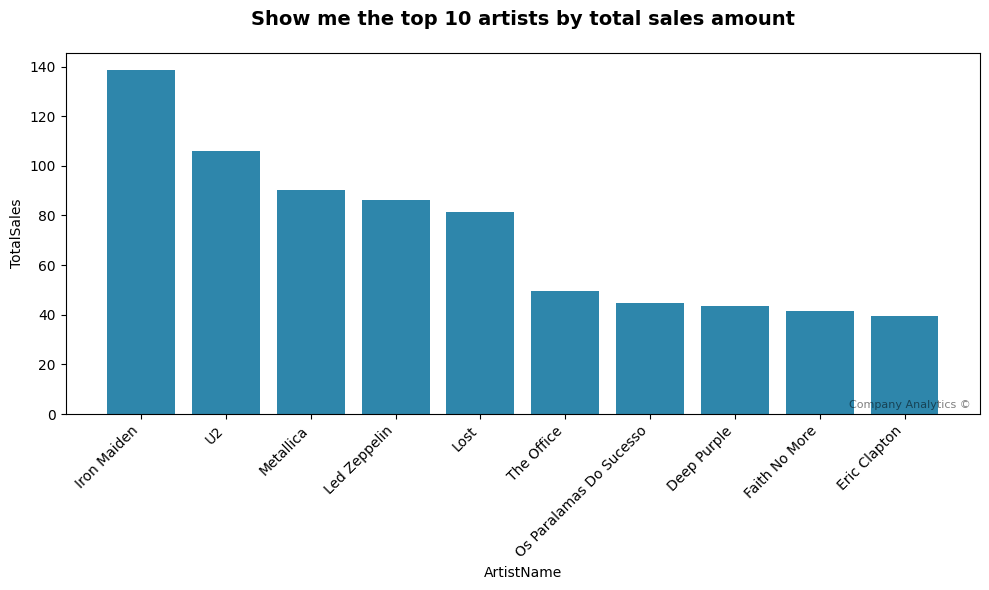

In [15]:
print("TEST 1: Top 10 Selling Artists")
result1 = run_complete_workflow(
    "Show me the top 10 artists by total sales amount",
    user_role="analyst"
)